# Cognition & Computation project

In [260]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as tv
import tqdm
from DBN import DBN
import torch.nn.functional as functional
from sklearn.metrics import confusion_matrix
import scipy.cluster as cluster
import seaborn as sns
from skimage.util import random_noise

In [132]:
class PreprocParams:
    crop_size = 28
    mean = 0.1307
    std = 0.3081
    visualization_threshold = 0.1
    image_size = crop_size
    noise_level = 0.2
    strategy = 'MNIST'

In [222]:
class DataProperties:
    classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [283]:
def inject_noise(data, noise_level):
  random_gaussian_tensor = torch.randn(data.shape)/6.6 + .6
  probability_tensor = torch.ones(data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return data - mask_tensor * data + mask_tensor * random_gaussian_tensor



## Data

In [112]:
def get_data():
    mnist_train = tv.datasets.MNIST('data/', train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))

    mnist_test = tv.datasets.MNIST("data/",
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))
    mnist_train.data = (mnist_train.data.type(torch.FloatTensor)/255)
    mnist_test.data = (mnist_test.data.type(torch.FloatTensor)/255)

    return mnist_train, mnist_test


In [113]:
def move_parameters_to_cpu(dbn_mnist):
  for layer in dbn_mnist.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu()
    layer.v_bias = layer.v_bias.cpu()

In [114]:
def get_mask(label, targets):  # we use this function to filter by class
    # labels = mnist_targets_train.numpy()
    return targets.numpy() == label

In [115]:
mnist_train, mnist_test = get_data()

data_train = mnist_train.data
targets_train = mnist_train.targets

data_test = mnist_test.data
targets_test = mnist_test.targets


In [116]:
class DBNShallowParams:
    visible_units=28*28
    hidden_units=[500]
    k=1
    learning_rate=0.1
    learning_rate_decay=False
    initial_momentum=0.5
    final_momentum=0.9
    weight_decay=0.0002
    xavier_init=False
    increase_to_cd_k=False
    use_gpu=True

class DBNDeepParams:
    visible_units=28*28
    hidden_units=[500, 500]
    k=1
    learning_rate=0.1
    learning_rate_decay=False
    initial_momentum=0.5
    final_momentum=0.9
    weight_decay=0.0002
    xavier_init=False
    increase_to_cd_k=False
    use_gpu=True

class TrainParameters:
    epochs = 40  # 50
    batch_size = 125  # 100
    class_num = 10

## Data exploration

### Visualization

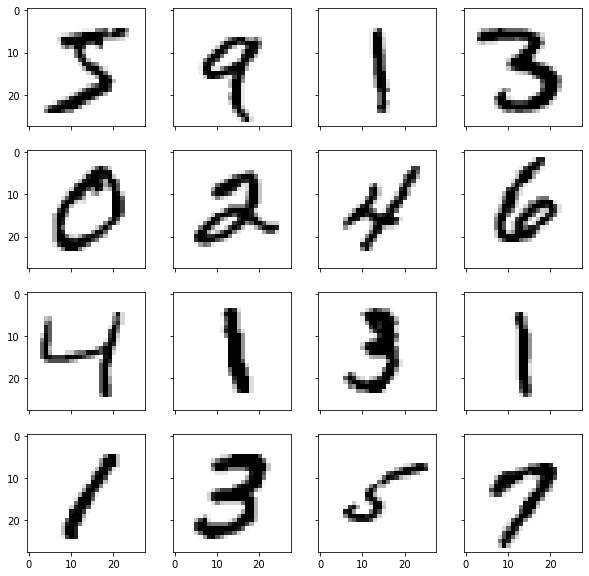

In [117]:
def visualize_symbols(dataset, n_subplots, image_shape):
    n_rows_cols = int(math.sqrt(n_subplots))
    _, axes = plt.subplots(
        n_rows_cols, 
        n_rows_cols, 
        sharex = True,
        sharey = True,
        figsize = (10, 10)
    )
    for i in range(n_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        img = dataset[i] 
        axes[row, col].imshow(torch.flatten(img).reshape(image_shape), cmap='binary')

visualize_symbols(
    data_train, 
    n_subplots = 16, 
    image_shape = (28, 28)
)

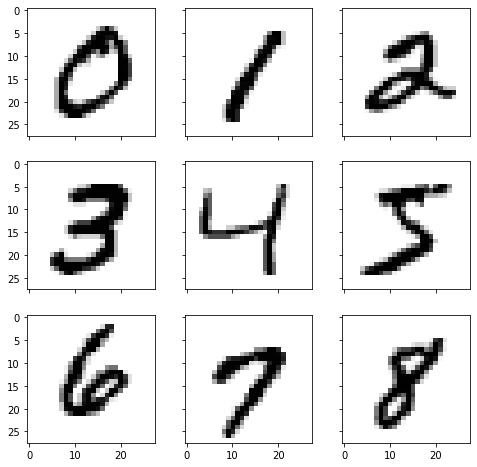

In [118]:
def visualize_labels(labels, data, targets, figsize = (10, 10)):
    n_subplots = len(labels)
    
    n_rows_cols = int(math.sqrt(n_subplots))
    _, axes = plt.subplots(
        n_rows_cols, 
        n_rows_cols, 
        sharex = True,
        sharey = True,
        figsize = figsize
    )

    for i in range(n_subplots):
        col = i % n_rows_cols
        row = i // n_rows_cols
        label = labels[i]
        
        img_index = np.where(targets == label)[0][0]
        image = data[img_index]
        axes[row, col].imshow(image, cmap = 'binary')

def prepare_data(ds, label_from, label_to):
    labels = []
    images = []
    for item in ds:
        if label_from <= item[1] <= label_to:
            labels.append(item[1])
            images.append(item[0])
    return images, labels


visualize_labels(
    labels = [
        0, 1, 2,
        3, 4, 5,
        6, 7, 8
    ],
    data = data_train,
    targets = targets_train,
    figsize = (8, 8)
)

### Class distribution

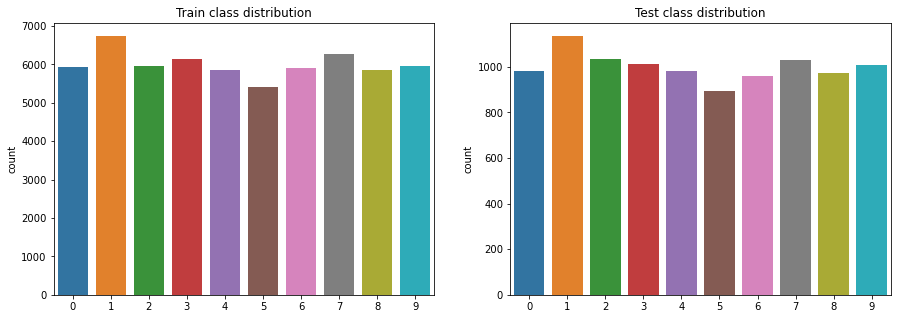

In [119]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
sns.countplot(
    x = targets_train.numpy(), ax = axes[0]

)
_ = axes[0].set_title('Train class distribution')

sns.countplot(
    x = targets_test.numpy(), 
    ax = axes[1]
)
_ = axes[1].set_title('Test class distribution')

## Model prepare & train

In [120]:
dbn_shallow = DBN(
    visible_units = DBNShallowParams.visible_units,
    hidden_units = DBNShallowParams.hidden_units,
    k = DBNShallowParams.k,
    learning_rate = DBNShallowParams.learning_rate,
    learning_rate_decay = DBNShallowParams.learning_rate_decay,
    initial_momentum = DBNShallowParams.initial_momentum,
    final_momentum = DBNShallowParams.final_momentum,
    weight_decay = DBNShallowParams.weight_decay,
    xavier_init = DBNShallowParams.xavier_init,
    increase_to_cd_k = DBNShallowParams.increase_to_cd_k,
    use_gpu = DBNShallowParams.use_gpu
)

dbn_deep = DBN(
    visible_units = DBNDeepParams.visible_units,
    hidden_units = DBNDeepParams.hidden_units,
    k = DBNDeepParams.k,
    learning_rate = DBNDeepParams.learning_rate,
    learning_rate_decay = DBNDeepParams.learning_rate_decay,
    initial_momentum = DBNDeepParams.initial_momentum,
    final_momentum = DBNDeepParams.final_momentum,
    weight_decay = DBNDeepParams.weight_decay,
    xavier_init = DBNDeepParams.xavier_init,
    increase_to_cd_k = DBNDeepParams.increase_to_cd_k,
    use_gpu = DBNDeepParams.use_gpu
)


In [121]:
def apply_threshold(weights, threshold=0):
    return weights * (abs(weights) > threshold)

In [122]:
class Perceptron(torch.nn.Module):
  def __init__(self, rbm_layer_size, class_num, n_hidden_layer):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, class_num)
    self.n_hidden_layer = n_hidden_layer  # number of hidden layer, where we attach perceptron
  
  def forward(self, x):
    return self.linear(x)

In [123]:
class DBNAggreg:
    def __init__(self, dbn_model, n_classes):
        self.dbn_model = dbn_model
        self.n_classes = n_classes
        
        self.hidden_representations_train = []
        self.hidden_representations_test = []
        self.noisy_hidden_representations = []
        
        self.learned_weights = []
        self.weight_products = []
        self.processed_weight_products = []

        self.label_to_mean_hidden_representations = []
        self.mean_hidden_representation_matrices = []

        self.attached_perceptrons = []

    def n_layers(self):
        return len(self.dbn_model.rbm_layers)
    
    def train_dbn(self, data, targets, train_parameters):
        self.dbn_model.train_static(
            data,
            targets,
            train_parameters.epochs,
            train_parameters.batch_size
        )
        move_parameters_to_cpu(self.dbn_model)

    def get_layer_repr(self, data, n_layer):
        flattened_input = data.view((data.shape[0], -1)).type(torch.FloatTensor)
        hidden_repr, _ = self.dbn_model.rbm_layers[n_layer].to_hidden(flattened_input)
        return hidden_repr

    def get_hidden_representations(self, data):
        res = []
        print(f'Total: {self.n_layers()} hidden layers')
        for i in range(self.n_layers()):
            if i == 0:
                repr = self.get_layer_repr(data, n_layer = i)
            else:
                input = res[i - 1]  # Prev hidden representation layer
                repr = self.get_layer_repr(input, n_layer = i)
            res.append(repr)
        return res
    
    def calc_train_representations(self, data):
        self.hidden_representations_train = self.get_hidden_representations(data)
    
    def calc_noisy_representations(self, noisy_data):
        self.noisy_hidden_representations = self.get_hidden_representations(noisy_data)
    
    def calc_test_representations(self, data):
        self.hidden_representations_test = self.get_hidden_representations(data)

    def get_learned_weights(self):
        self.learned_weights = []
        for i in range(self.n_layers()):
            self.learned_weights.append(self.dbn_model.rbm_layers[i].W.numpy())

    def get_weight_products(self):
        self.weight_products = []
        for i, w in enumerate(self.learned_weights):
            if i == 0:
                self.weight_products.append(w)
            else:
                cur_w = self.learned_weights[0]
                for j in range(1, i + 1):
                    cur_w = cur_w @ self.learned_weights[j]
                self.weight_products.append(cur_w)
    
    def get_processed_weight_products(self):
        self.processed_weight_products = [apply_threshold(w) for w in self.weight_products]


    def get_label_to_mean_hidden_representations(self, targets):
        self.label_to_mean_hidden_representations = [
            self.get_label_to_mean_hidden_representation(h, targets)
            for h in self.hidden_representations_train
        ]
    
    def get_mean_hidden_representation_matrices(self):
        self.mean_hidden_representation_matrices = [
            self.get_hidden_reprs_matrix(l_to_mean)
            for l_to_mean in self.label_to_mean_hidden_representations
        ]

    def get_label_to_mean_hidden_representation(self, hidden_repr, targets):
        hidden_representation_np = hidden_repr.numpy()
        return {
            label: hidden_representation_np[get_mask(label, targets)].mean(axis=0)
            for label in range(self.n_classes)
        }
    
    def get_hidden_reprs_matrix(self, l_to_mean):
        return np.concatenate(
            [np.expand_dims(l_to_mean[label], axis=0)
            for label in range(self.n_classes)]
        )

    def create_perceptron(self, n_layer):
        rbm_layer_size = self.dbn_model.rbm_layers[n_layer].W.shape[1]
        return Perceptron(
            rbm_layer_size, 
            class_num = self.n_classes, 
            n_hidden_layer = n_layer
        )
    
    def attach_perceptrons(self, n_layers):
        for layer in n_layers:
            p = self.create_perceptron(n_layer = layer)  # attach to hidden layer
            self.attached_perceptrons.append(p)
        
    def train_perceptron(self, perceptron, n_layer, targets, epochs):
        _train(
            model = perceptron, 
            input = self.hidden_representations_train[n_layer], 
            targets = targets, 
            epochs = epochs
        )
    
    def train_perceptrons(self, targets, epochs):
        for p in self.attached_perceptrons:
            layer = p.n_hidden_layer
            print(f'Train perceptron, attached to: {layer} hidden layer')
            self.train_perceptron(p, layer, targets, epochs)


    def perceptron_accuracy(self, n_layer, targets):
        test_repr = self.hidden_representations_test[n_layer]
        # REMEMBER that attached perceptrons should go in order (not attach to layer 1, 4, 7, but 1, 2, 3, 4, 5, 6, 7)
        p = self.attached_perceptrons[n_layer]
        predictions = p(test_repr)
        return compute_accuracy(predictions, targets)

In [124]:
model_deep = DBNAggreg(
    dbn_model = dbn_deep,
    n_classes = 10
)

model_shallow = DBNAggreg(
    dbn_model = dbn_shallow,
    n_classes = 10
)

In [125]:
model_deep.train_dbn(
    data = data_train,
    targets = targets_train,
    train_parameters = TrainParameters
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2201   |0.0611   |318.2672 |14.2392   |
|20    |1.1654   |0.0580   |303.9652 |11.7427   |
|30    |1.1474   |0.0571   |297.2999 |12.8558   |
|40    |1.1376   |0.0570   |292.5209 |12.0989   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.5925   |0.0473   |262.4820 |11.3369   |
|20    |1.5366   |0.0498   |256.3951 |10.3962   |
|30    |1.5183   |0.0479   |252.6714 |11.7176   |
|40    |1.5103   |0.0482   |250.3359 |10.2989   |


In [126]:
model_shallow.train_dbn(
    data = data_train,
    targets = targets_train,
    train_parameters = TrainParameters
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2205   |0.0616   |319.8754 |12.6857   |
|20    |1.1654   |0.0571   |304.6758 |12.6419   |
|30    |1.1513   |0.0586   |299.9995 |12.4216   |
|40    |1.1393   |0.0576   |294.5673 |10.9051   |


## Prepare hidden representations

In [127]:
def get_layer_repr(data, dbn_model, n_layer):
    flattened_input = data.view((data.shape[0], -1)).type(torch.FloatTensor)
    hidden_repr, _ = dbn_model.rbm_layers[n_layer].to_hidden(flattened_input)
    return hidden_repr

In [133]:
def perform_calculations(model):
    model.calc_train_representations(data_train)
    model.calc_noisy_representations(data_test)

    noisy_data = inject_noise(data_test, PreprocParams.noise_level)
    model.calc_test_representations(noisy_data)
    
    model.get_learned_weights()
    model.get_weight_products()
    model.get_processed_weight_products()
    
    model.get_label_to_mean_hidden_representations(targets = targets_train)
    model.get_mean_hidden_representation_matrices()
    
perform_calculations(model_deep)
perform_calculations(model_shallow)

Total: 2 hidden layers
Total: 2 hidden layers
Total: 2 hidden layers
Total: 1 hidden layers
Total: 1 hidden layers
Total: 1 hidden layers


## Layer receptive fields

In [134]:
def plot_layer_receptive_fields(weights):
  num_subplots = 64
  n_rows_cols = int(math.sqrt(num_subplots))
  _, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[:, i].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

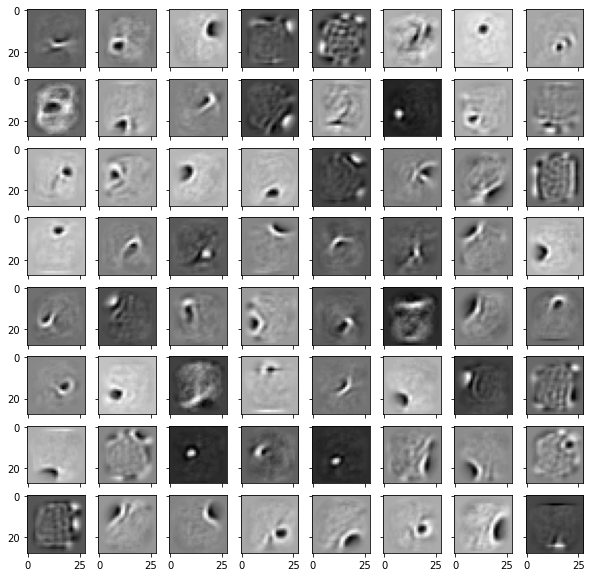

In [135]:
plot_layer_receptive_fields(
    model_deep.processed_weight_products[0]
)

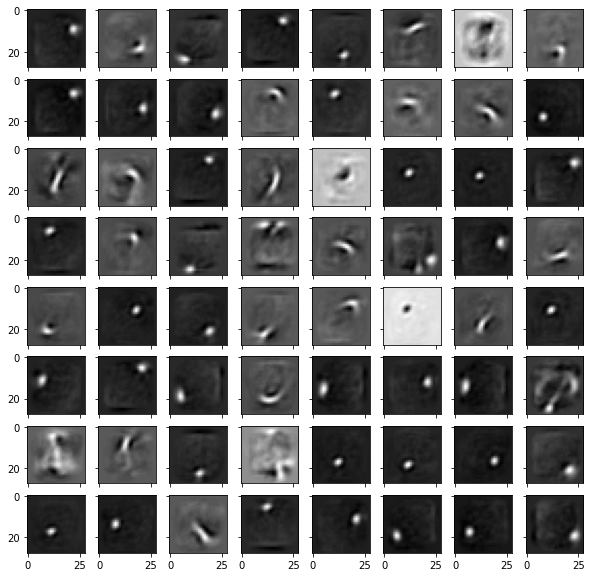

In [136]:
plot_layer_receptive_fields(
    model_deep.processed_weight_products[1]
)

## Clustering internal representations

In [137]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  _ = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

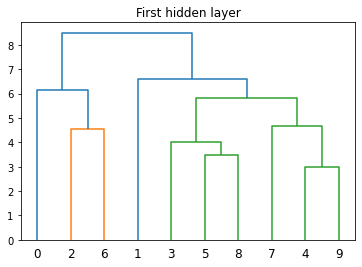

In [138]:
plot_dendrogram(
    model_deep.mean_hidden_representation_matrices[0], "First hidden layer"
)

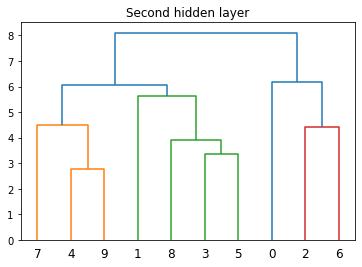

In [139]:
plot_dendrogram(
    model_deep.mean_hidden_representation_matrices[1], 'Second hidden layer'
)

## Train perceptrons (readout layers)

In [140]:
def _train(model, input, targets, epochs=1000):
  print_every_n_epochs = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(input).squeeze()
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0:
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss))

In [141]:
def compute_accuracy(predictions, targets):
  predictions_indices = predictions.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [142]:
model_deep.attach_perceptrons(
    n_layers = [0, 1]  # to which hidden layers attach perceptrons
)

model_deep.train_perceptrons(
    targets = targets_train,
    epochs = 1500
)

Train perceptron, attached to: 0 hidden layer
epoch 0/1500, loss = 2.289785
epoch 100/1500, loss = 0.653757
epoch 200/1500, loss = 0.494625
epoch 300/1500, loss = 0.430103
epoch 400/1500, loss = 0.393239
epoch 500/1500, loss = 0.368611
epoch 600/1500, loss = 0.350604
epoch 700/1500, loss = 0.336644
epoch 800/1500, loss = 0.325367
epoch 900/1500, loss = 0.315977
epoch 1000/1500, loss = 0.307974
epoch 1100/1500, loss = 0.301028
epoch 1200/1500, loss = 0.294910
epoch 1300/1500, loss = 0.289455
epoch 1400/1500, loss = 0.284541
Train perceptron, attached to: 1 hidden layer
epoch 0/1500, loss = 2.323442
epoch 100/1500, loss = 0.680482
epoch 200/1500, loss = 0.509454
epoch 300/1500, loss = 0.440510
epoch 400/1500, loss = 0.401297
epoch 500/1500, loss = 0.375193
epoch 600/1500, loss = 0.356166
epoch 700/1500, loss = 0.341455
epoch 800/1500, loss = 0.329599
epoch 900/1500, loss = 0.319749
epoch 1000/1500, loss = 0.311369
epoch 1100/1500, loss = 0.304108
epoch 1200/1500, loss = 0.297721
epoch 13

In [143]:
model_shallow.attach_perceptrons(
    n_layers = [0]
)

model_shallow.train_perceptrons(
    targets = targets_train,
    epochs = 1500
)

Train perceptron, attached to: 0 hidden layer
epoch 0/1500, loss = 2.279653
epoch 100/1500, loss = 0.658573
epoch 200/1500, loss = 0.495695
epoch 300/1500, loss = 0.429915
epoch 400/1500, loss = 0.392444
epoch 500/1500, loss = 0.367455
epoch 600/1500, loss = 0.349207
epoch 700/1500, loss = 0.335070
epoch 800/1500, loss = 0.323656
epoch 900/1500, loss = 0.314156
epoch 1000/1500, loss = 0.306060
epoch 1100/1500, loss = 0.299035
epoch 1200/1500, loss = 0.292847
epoch 1300/1500, loss = 0.287330
epoch 1400/1500, loss = 0.282361


## Train Feedforward model

In [61]:
class Feedforward(torch.nn.Module):
  def __init__(self, input_size, first_hidden_layer_size, output_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(input_size, first_hidden_layer_size)
    self.output = torch.nn.Linear(first_hidden_layer_size, output_size)

  def forward(self, input):
    input = input.view((input.shape[0], -1))
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    output = self.output(first_hidden_repr)
    return output

In [62]:
ffnn = Feedforward(
    input_size = 784,
    first_hidden_layer_size = 500,
    output_size = 10
)

In [63]:
_train(
    ffnn, 
    data_train,
    targets = targets_train, 
    epochs=120
)

epoch 0/120, loss = 2.300125
epoch 10/120, loss = 2.192559
epoch 20/120, loss = 2.074143
epoch 30/120, loss = 1.932819
epoch 40/120, loss = 1.769810
epoch 50/120, loss = 1.595083
epoch 60/120, loss = 1.423038
epoch 70/120, loss = 1.266726
epoch 80/120, loss = 1.133159
epoch 90/120, loss = 1.023105
epoch 100/120, loss = 0.933791
epoch 110/120, loss = 0.861361


## Compare FFNN with readout performance

In [188]:
accuracies = {
}

accuracies['1st layer\ndeep'] = model_deep.perceptron_accuracy(n_layer = 0, targets = targets_test)
accuracies['1st layer\nshallow'] = model_shallow.perceptron_accuracy(n_layer = 0, targets = targets_test)
accuracies['2nd layer\ndeep'] = model_deep.perceptron_accuracy(n_layer = 1, targets = targets_test)
accuracies['FFNN'] = compute_accuracy(
    ffnn(data_test),
    targets_test
)

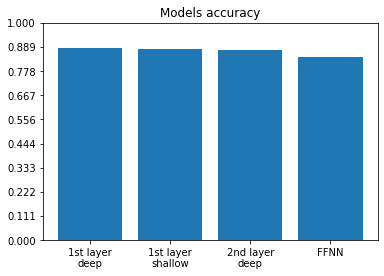

In [189]:
plt.bar(accuracies.keys(), accuracies.values())
plt.title('Models accuracy')
_ = plt.yticks(np.linspace(0, 1, 10))

## Robustness to noise

### Noise type visualization

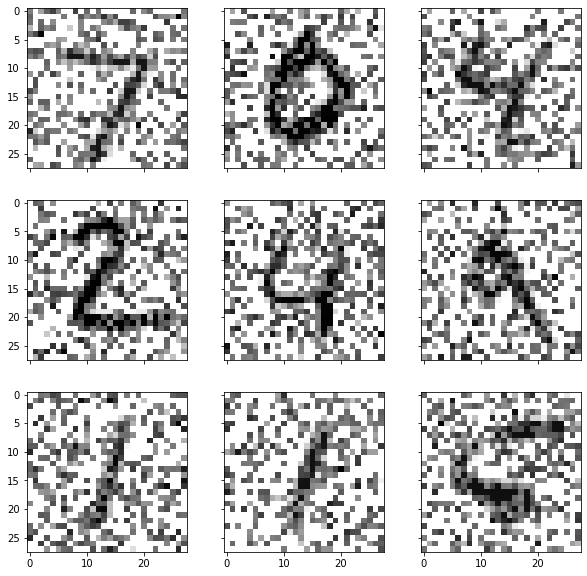

In [325]:
visualize_symbols(
    inject_noise(data_test, noise_level = 0.4), 
    n_subplots = 9, 
    image_shape = (28, 28)
)

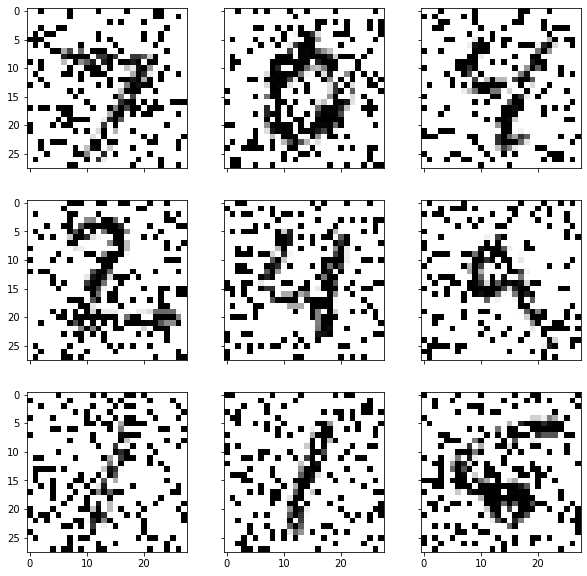

In [332]:
def inject_sp_noise(data, noise_level):
  res = torch.tensor(random_noise(data, mode='s&p', amount = noise_level))
  return res

# Salt and pepper noise
visualize_symbols(
    inject_sp_noise(data_test, noise_level = 0.4), 
    n_subplots = 9, 
    image_shape = (28, 28)
)

### Noise robustness curves

In [327]:
def get_accuracy_values_at_noise_level(
  data,
  targets,
  noise_level,
  dbn_model,
  n_layer,  # representation
  perceptron_model,
  ffnn_model,
  noise_type
  ):

  if noise_type == 'Bernouli':
    noisy_data = inject_noise(data, noise_level)
  if noise_type == 'Salt & Pepper':
    noisy_data = inject_sp_noise(data, noise_level)

  if perceptron_model is not None:
    noisy_hidden_representations = dbn_model.get_hidden_representations(noisy_data)
    hidden_repr_noisy = noisy_hidden_representations[n_layer]  # get_layer_repr(data = noisy_data, dbn_model = dbn_model, n_layer = n_layer)
    predictions_perceptron = perceptron_model(hidden_repr_noisy)  
    accuracy_perceptron = compute_accuracy(predictions_perceptron, targets)
  else:
    accuracy_perceptron = None

  if ffnn_model is not None:
    predictions_ffnn = ffnn_model(noisy_data) #.reshape((noisy_data.shape[0], 784)))
    accuracy_ffnn = compute_accuracy(predictions_ffnn, targets)
  else:
    accuracy_ffnn = None
  
  return accuracy_perceptron, accuracy_ffnn

In [329]:
get_accuracy_values_at_noise_level(
    data = data_test,
    targets = targets_test,
    noise_level = PreprocParams.noise_level,
    # dbn_model = model_deep.dbn_model,
    dbn_model = model_deep,
    n_layer = 0,
    perceptron_model = model_deep.attached_perceptrons[0],
    ffnn_model = ffnn,
    noise_type = 'Bernouli'
)

Total: 2 hidden layers


(0.8859000205993652, 0.8205999732017517)

In [331]:
get_accuracy_values_at_noise_level(
    data = data_test,
    targets = targets_test,
    noise_level = PreprocParams.noise_level,
    # dbn_model = model_deep.dbn_model,
    dbn_model = model_deep,
    n_layer = 0,
    perceptron_model = model_deep.attached_perceptrons[0],
    ffnn_model = ffnn,
    noise_type = 'Salt & Pepper'
)

Total: 2 hidden layers


(0.8770999908447266, 0.8123000264167786)

In [336]:
def plot_noise_robustness_curves(
  noise_levels,
  data,
  targets,
  dbn_model,
  n_layer,
  perceptron_model,
  ffnn_model,
  noise_type
  ):
  accuracies_perceptron = []
  accuracies_ffnn = []
  
  for noise_level in noise_levels:
    accuracy_perceptron, accuracy_ffnn = get_accuracy_values_at_noise_level(
      data = data,
      targets = targets,
      noise_level = noise_level,
      dbn_model = dbn_model,
      n_layer = n_layer,
      perceptron_model = perceptron_model,
      ffnn_model = ffnn_model,
      noise_type = noise_type
    )
    accuracies_perceptron.append(accuracy_perceptron)
    accuracies_ffnn.append(accuracy_ffnn)
  
  fig, ax = plt.subplots()
  ax.plot(
    range(len(noise_levels)), accuracies_perceptron,
    marker = 'o',
    markerfacecolor = 'white', 
    markersize = 9
  )
  ax.plot(
    range(len(noise_levels)), accuracies_ffnn,
    marker = 'o',
    markerfacecolor = 'white', 
    markersize = 9
  )
  
  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.grid()
  plt.legend(["First hidden", "FFNN"])

In [342]:
def get_ffnn_accuracies(
  noise_levels,
  data,
  targets,
  ffnn_model,
  noise_type
  ):
  accuracies_ffnn = []
  
  for noise_level in noise_levels:
    _, accuracy_ffnn = get_accuracy_values_at_noise_level(
      data = data,
      targets = targets,
      noise_level = noise_level,
      dbn_model = None,
      n_layer = None,
      perceptron_model = None,
      ffnn_model = ffnn_model,
      noise_type=noise_type
    )
    accuracies_ffnn.append(accuracy_ffnn)
  return accuracies_ffnn

In [343]:
def get_perceptron_accuracies(noise_levels, data, targets, dbn_model, n_layer, noise_type):
    accuracies_perceptron = []
  
    for noise_level in noise_levels:
        accuracy_perceptron, _ = get_accuracy_values_at_noise_level(
        data = data,
        targets = targets,
        noise_level = noise_level,
        dbn_model = dbn_model,
        n_layer = n_layer,
        perceptron_model = dbn_model.attached_perceptrons[n_layer],
        ffnn_model = None,
        noise_type = noise_type
        )
        accuracies_perceptron.append(accuracy_perceptron)
    return accuracies_perceptron

In [344]:
%%capture
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
accuracies = {}
noise_type = 'Bernouli'

accuracies['1st hidden (shallow)'] = get_perceptron_accuracies(
    noise_levels,
    data_test,
    targets_test,
    dbn_model = model_shallow,
    n_layer = 0,
    noise_type = noise_type
)

accuracies['1st hidden (deep)'] = get_perceptron_accuracies(
    noise_levels,
    data_test,
    targets_test,
    dbn_model = model_deep,
    n_layer = 0,
    noise_type = noise_type
)

accuracies['FFNN'] = get_ffnn_accuracies(
    noise_levels, 
    data_test, 
    targets_test, 
    ffnn,
    noise_type = noise_type
)

In [350]:
%%capture
accuracies_sp = {}
noise_type = 'Salt & Pepper'

accuracies_sp['1st hidden (shallow)'] = get_perceptron_accuracies(
    noise_levels,
    data_test,
    targets_test,
    dbn_model = model_shallow,
    n_layer = 0,
    noise_type = noise_type
)

accuracies_sp['1st hidden (deep)'] = get_perceptron_accuracies(
    noise_levels,
    data_test,
    targets_test,
    dbn_model = model_deep,
    n_layer = 0,
    noise_type = noise_type
)

accuracies_sp['FFNN'] = get_ffnn_accuracies(
    noise_levels, 
    data_test, 
    targets_test, 
    ffnn,
    noise_type = noise_type
)

Text(0.5, 0, 'Noise level')

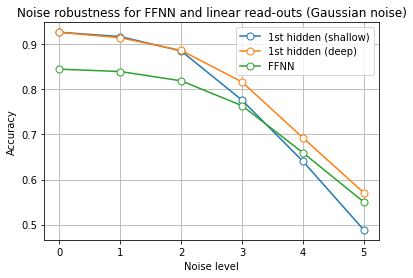

In [352]:
for k, v in accuracies.items():
    _ = plt.plot(
        v,
        marker = 'o',
        markerfacecolor = 'white', 
        markersize = 7
    )
plt.grid()
plt.legend(accuracies.keys())
plt.title('Noise robustness for FFNN and linear read-outs (Gaussian noise)')
plt.ylabel('Accuracy')
plt.xlabel('Noise level')

Text(0.5, 0, 'Noise level')

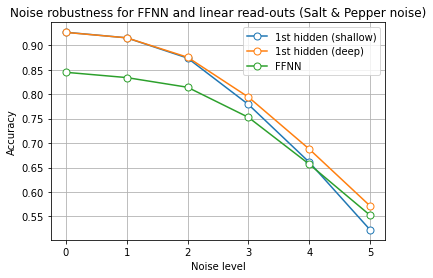

In [353]:
for k, v in accuracies_sp.items():
    _ = plt.plot(
        v,
        marker = 'o',
        markerfacecolor = 'white', 
        markersize = 7
    )
plt.grid()
plt.legend(accuracies.keys())
plt.title('Noise robustness for FFNN and linear read-outs (Salt & Pepper noise)')
plt.ylabel('Accuracy')
plt.xlabel('Noise level')

Total: 2 hidden layers
Total: 2 hidden layers
Total: 2 hidden layers
Total: 2 hidden layers
Total: 2 hidden layers
Total: 2 hidden layers


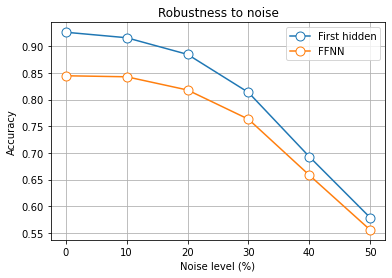

In [348]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5] #, 0.6, 0.7, 0.8]

plot_noise_robustness_curves(
    noise_levels = noise_levels,
    data = data_test,
    targets = targets_test,
    dbn_model = model_deep, 
    n_layer = 0,
    perceptron_model = model_deep.attached_perceptrons[0],
    ffnn_model = ffnn,
    noise_type = 'Bernouli'
)

Total: 1 hidden layers
Total: 1 hidden layers
Total: 1 hidden layers
Total: 1 hidden layers
Total: 1 hidden layers
Total: 1 hidden layers


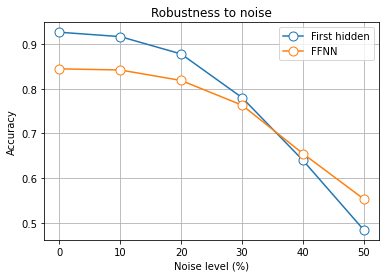

In [349]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5] #, 0.6, 0.7, 0.8]

plot_noise_robustness_curves(
    noise_levels = noise_levels,
    data = data_test,
    targets = targets_test,
    dbn_model = model_shallow, 
    n_layer = 0,
    perceptron_model = model_shallow.attached_perceptrons[0],
    ffnn_model = ffnn,
    noise_type = 'Bernouli'
)

## Example of adversarial attacks

In [190]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

In [191]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, perceptron):
        super().__init__()
        self.readout = perceptron
        self.dbn_mnist = dbn_mnist

    def forward(self, image):
        x, _ = self.dbn_mnist.forward(image)
        x = self.readout.forward(x)
        return x

In [193]:
dbn_with_readout = DBNWithReadOut(
    model_shallow.dbn_model, 
    perceptron = model_shallow.attached_perceptrons[0]
)

In [194]:
def attack_demo(image, label, attacked_model):
    f = plt.figure()
    s1 = f.add_subplot(1, 2, 1)
    s2 = f.add_subplot(1, 2, 2)
    
    s1.imshow(
        image.reshape(PreprocParams.crop_size, PreprocParams.crop_size)
    )

    image.requires_grad = True
    model_output = attacked_model(image)
    pred = torch.argmax(model_output)

    s1.set_title(
        f"""
        Image before
        True label: {label}
        Predicted label: {pred}
        """
    )

    loss = torch.nn.functional.cross_entropy(
        target = torch.tensor([label]),
        input = model_output
    )
    
    attacked_model.zero_grad()
    loss.backward()

    image_grad = image.grad.data
    perturbed_image = fgsm_attack(image, 0.2, image_grad)
    perturbed_image_np = perturbed_image.detach().numpy()

    pred_adversarial = torch.argmax(
        attacked_model(perturbed_image)
    )
    
    s2.imshow(
        perturbed_image_np.reshape(PreprocParams.crop_size, PreprocParams.crop_size)
    )
    s2.set_title(
        f"""
        Image after adv. attack
        True label: {label}
        Predicted label: {pred_adversarial}
        """
    )

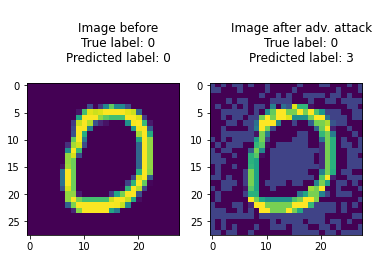

In [195]:
idx = 10
test_label = targets_test[idx]
test_image = data_test[idx].reshape(
    1, 
    PreprocParams.crop_size, 
    PreprocParams.crop_size
)

attack_demo(
    image = test_image,
    label = test_label,
    attacked_model = ffnn
)

## Robustness to adversarial attacks

In [196]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm.tqdm(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.reshape(1, 28, 28)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)
        # If the initial predi ction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data.detach().numpy().reshape(28,28))
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_mnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(perturbed_data.detach().numpy().reshape(28,28))
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    if verbose:
      print("\nEpsilon: {}\tTest Accuracy = {} / {} = {}\n".format(epsilon,
            correct, len(test_loader), final_acc))

    return final_acc

In [197]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.MNIST('data/', train=False, download=False, transform=tv.transforms.Compose([
        tv.transforms.ToTensor(),
    ])),
    batch_size=1, shuffle=True)

In [198]:
device = torch.device("cpu")

In [199]:
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

100%|██████████| 10000/10000 [00:14<00:00, 686.36it/s]


Epsilon: 0.1	Test Accuracy = 5457 / 10000 = 0.5457



In [200]:
final_acc = test_robustness_to_attack(
    dbn_with_readout,
    device,
    test_loader, 
    epsilon=0.1,
    num_steps=0
)

100%|██████████| 10000/10000 [00:10<00:00, 988.76it/s]


Epsilon: 0.1	Test Accuracy = 6495 / 10000 = 0.6495



  0%|          | 0/10000 [00:00<?, ?it/s]


Here's the original sample:



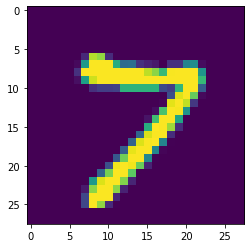


Here's a perturbed sample:



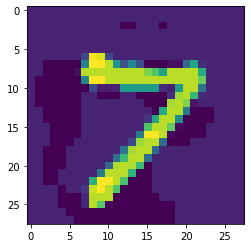


Here's what a 1-steps reconstructed sample looks like:



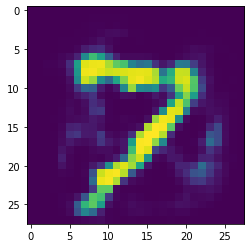

100%|██████████| 10000/10000 [00:14<00:00, 695.80it/s]


Epsilon: 0.1	Test Accuracy = 7608 / 10000 = 0.7608



In [163]:
final_acc = test_robustness_to_attack(
    dbn_with_readout, 
    device,
    test_loader, 
    epsilon = 0.1,
    num_steps = 1
)

## Effect of $\epsilon$

In [159]:
def test_epsilon_values_effect(epsilons, model, device, loader, n_steps):
  accuracies = list()

  for eps in epsilons:
      acc = test_robustness_to_attack(model, device, loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [160]:
epsilons = [0, 0.1, 0.2]  # [0, .05, .1, .15, .2, .25]
accuracies_ffnn = test_epsilon_values_effect(epsilons, ffnn, device, test_loader, n_steps=0)
accuracies_rbm_0 = test_epsilon_values_effect(epsilons, dbn_with_readout, device, test_loader, n_steps=0)
accuracies_rbm_1 = test_epsilon_values_effect(epsilons, dbn_with_readout, device, test_loader, n_steps = 1)
accuracies_rbm_2 = test_epsilon_values_effect(epsilons, dbn_with_readout, device, test_loader, n_steps = 2)

100%|██████████| 10000/10000 [00:20<00:00, 485.03it/s]


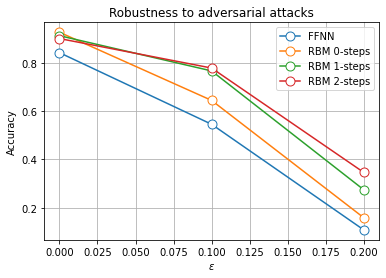

In [193]:
fig, ax = plt.subplots(1, 1, figsize=(6,4), sharey=True)

__ = ax.plot(
    epsilons, accuracies_ffnn,
    marker = 'o',
    markerfacecolor = 'white', 
    markersize = 9
)
__ = ax.plot(
    epsilons, accuracies_rbm_0,
    marker = 'o',
    markerfacecolor = 'white', 
    markersize = 9
)
__ = ax.plot(
    epsilons, accuracies_rbm_1,
    marker = 'o',
    markerfacecolor = 'white', 
    markersize = 9
)
__ = ax.plot(
    epsilons, accuracies_rbm_2,
    marker = 'o',
    markerfacecolor = 'white', 
    markersize = 9
)
__ = ax.set_xlabel("$\epsilon$")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks")
plt.grid()
__ = ax.legend(["FFNN", "RBM 0-steps", "RBM 1-steps","RBM 2-steps"])

## Confusion matrix analysis

### Confusion matrices

In [254]:
def get_perceptron_predictions(dbn_model, n_layer):
    test_repr = dbn_model.hidden_representations_test[n_layer]
    # REMEMBER that attached perceptrons should go in order (not attach to layer 1, 4, 7, but 1, 2, 3, 4, 5, 6, 7)
    p = dbn_model.attached_perceptrons[n_layer]
    predictions = p(test_repr)
    return predictions

def plot_perc_conf_matrix(dbn_model, n_layer, targets):
    pred = get_perceptron_predictions(
        dbn_model,
        n_layer
    )
    pred = pred.max(axis = 1).indices
    
    conf_mat = confusion_matrix(
        targets,
        pred.detach().numpy(),
        labels = DataProperties.classes,
        normalize = 'true'
    )

    _, ax = plt.subplots(figsize = (6, 6))
    sns.heatmap(
        conf_mat, 
        annot = True, 
        fmt = '.2f',
        xticklabels=DataProperties.classes,
        yticklabels=DataProperties.classes
    )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Perceptron: {n_layer + 1} hidden layer')

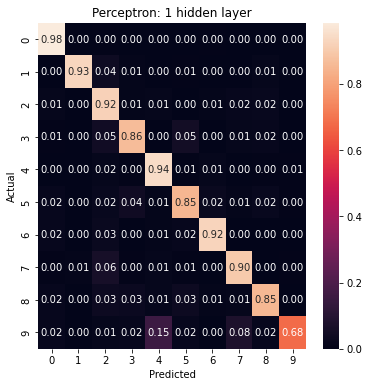

In [255]:
plot_perc_conf_matrix(
    dbn_model = model_deep,
    n_layer = 0,
    targets = targets_test
)

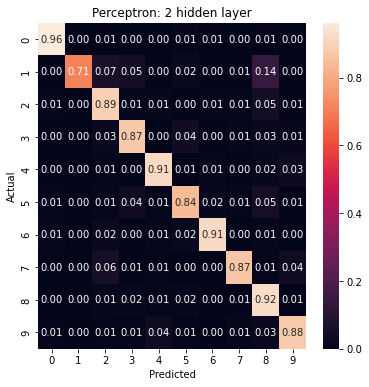

In [257]:
plot_perc_conf_matrix(
    dbn_model = model_deep,
    n_layer = 1,
    targets = targets_test
)

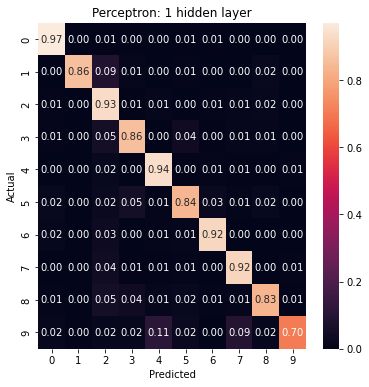

In [258]:
plot_perc_conf_matrix(
    dbn_model = model_shallow,
    n_layer = 0,
    targets = targets_test
)

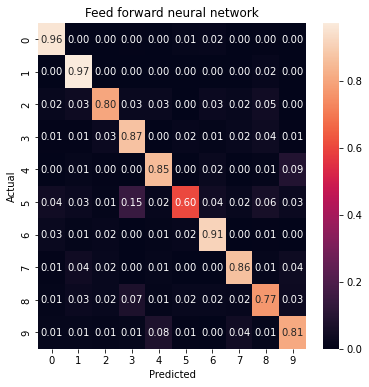

In [259]:
def plot_ffnn_confusion_matrix(ffnn_model, data, targets):
    predictions = ffnn_model(data)
    predictions = predictions.max(axis=1).indices  # convert probabilities to indices
    
    conf_mat = confusion_matrix(
        targets,
        predictions.detach().numpy(),
        labels = DataProperties.classes,
        normalize = 'true'
    )

    _, ax = plt.subplots(figsize = (6, 6))
    sns.heatmap(
        conf_mat, 
        annot = True, 
        fmt = '.2f',
        xticklabels=DataProperties.classes,
        yticklabels=DataProperties.classes
    )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Feed forward neural network')

plot_ffnn_confusion_matrix(
    ffnn_model = ffnn,
    data = data_test,
    targets = targets_test
)

### Mistaken images analysis

In [278]:
def find_mistake_indices(actual, predicted, pred, targets, how_many):
    mistakes = (pred != targets)
    res = []
    counter = 0
    for idx, m in enumerate(mistakes):
        if m == True and pred[idx] == predicted and targets[idx] == actual:
            res.append(idx)
            counter += 1
            if counter == how_many:
                return res
    return res

def plot_mistaken_images(actual, predicted, pred, targets, how_many):
    indices = find_mistake_indices(actual, predicted, pred, targets, how_many)
    for i in indices:
        _, ax = plt.subplots()
        ax.imshow(data_test[i].reshape((28, 28)))
        plt.title(f'Predicted: {predicted}\nActual: {actual}')


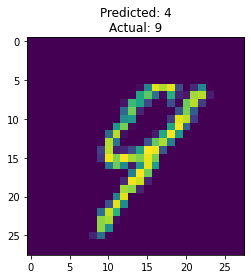

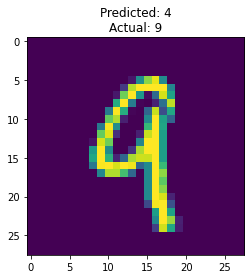

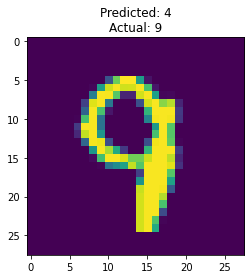

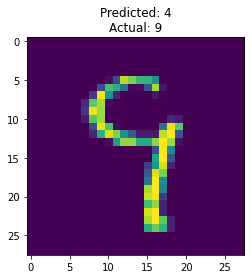

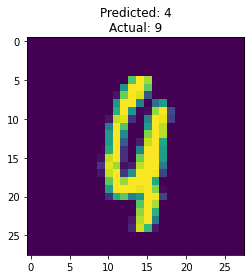

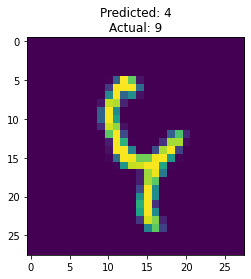

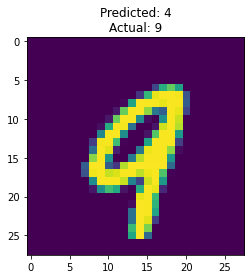

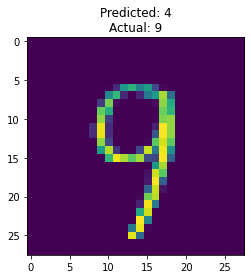

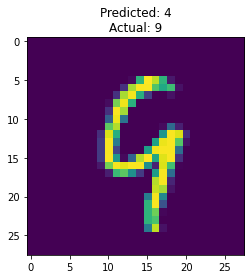

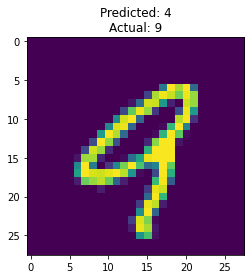

In [282]:
actual = 9
predicted = 4
max_to_plot = 10

pred = get_perceptron_predictions(
        dbn_model = model_deep,
        n_layer = 1
    ).max(axis = 1).indices
plot_mistaken_images(actual, predicted, pred, targets_test, how_many = max_to_plot)

## Contacts

- 📧 pavel.ianko@studenti.unipd.it